This version includes the timeframe that goes from January 2021 to September 2023

In [3]:
#pip install pyathena

In [4]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
table_name1 = 'daily_tx'
table_name2 = 'daily_sales'

In [7]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')

df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name1};', conn) # Transactions
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name2};', conn) # Sales / Money Received

/tmp/ipykernel_21/544572083.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name1};', conn) # Transactions
/tmp/ipykernel_21/544572083.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name2};', conn) # Sales / Money Received


In [8]:
# Merging both df, including all rows
df = df1.merge(df2, on=['date', 'payer', 'country'], how='outer')

In [9]:
df.shape

(103726, 5)

In [10]:
#Checking rows with 'amount' == 0
df[df['amount'] == 0] # ~ 2k 

,payer,country,date,count,amount
122,BANCO DE CREDITO PERU,PERU,2022-09-07,94,0.0
150,BANCO DE CREDITO PERU,PERU,2022-07-28,16,0.0
152,DIRECT DEPOSIT (BTS),MEXICO,2021-08-27,1,0.0
173,TELEDOLAR-NIC,NICARAGUA,2023-10-04,6,0.0
191,KORI,MALI,2023-03-05,2,0.0
...,...,...,...,...,...
103688,BANCO SANTANDER,MEXICO,2023-05-10,160,0.0
103689,CIBANCO,MEXICO,2021-09-11,160,0.0
103708,BANORTE,MEXICO,2023-01-19,25,0.0
103710,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2021-01-05,2,0.0


In [11]:
# Filtering rows where 'amount' is equal to 0
df = df[df['amount'] != 0]

In [12]:
df

,payer,country,date,count,amount
0,PROMERICA (GUA),GUATEMALA,2023-01-02,63,32765.79
1,GLOBAL ENVIOS,ECUADOR,2022-01-28,64,34550.00
2,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2022-11-08,53,25407.00
3,ZEEPAY,GHANA,2022-08-17,39,12809.00
4,BANCO DE GUAYAQUIL,ECUADOR,2022-08-19,133,33700.17
...,...,...,...,...,...
103721,NAFA,COTE D'IVOIRE (IVORY COAST),2023-08-19,1,496.00
103722,CHEDRAUI (INPAMEX),MEXICO,2022-05-24,1,-100.00
103723,NAFA,MALI,2023-07-28,1,725.00
103724,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2023-07-04,1,-200.00


In [13]:
df[(df['amount'] == 0) & (df['count'] != 0)]

,payer,country,date,count,amount


In [14]:
df[df['amount'] <= 0]

,payer,country,date,count,amount
6,NAIRAGRAM,NIGERIA,2022-04-12,5,-2000.0
10,EXPIRED ORDERS,PERU,2021-08-13,2,-226.0
30,EXPIRED ORDERS,MEXICO,2023-02-20,12,-5490.0
45,PROMERICA (GUA),GUATEMALA,2021-05-05,1,-200.0
50,EXPIRED ORDERS,MEXICO,2022-04-19,19,-10564.0
...,...,...,...,...,...
103712,EXPIRED ORDERS,HONDURAS,2021-04-30,1,-3400.0
103713,EXPIRED ORDERS,BOLIVIA,2022-01-10,1,-1000.0
103716,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2022-06-29,1,-220.0
103722,CHEDRAUI (INPAMEX),MEXICO,2022-05-24,1,-100.0


In [15]:
df['date'] = pd.to_datetime(df['date']) # Datetime format

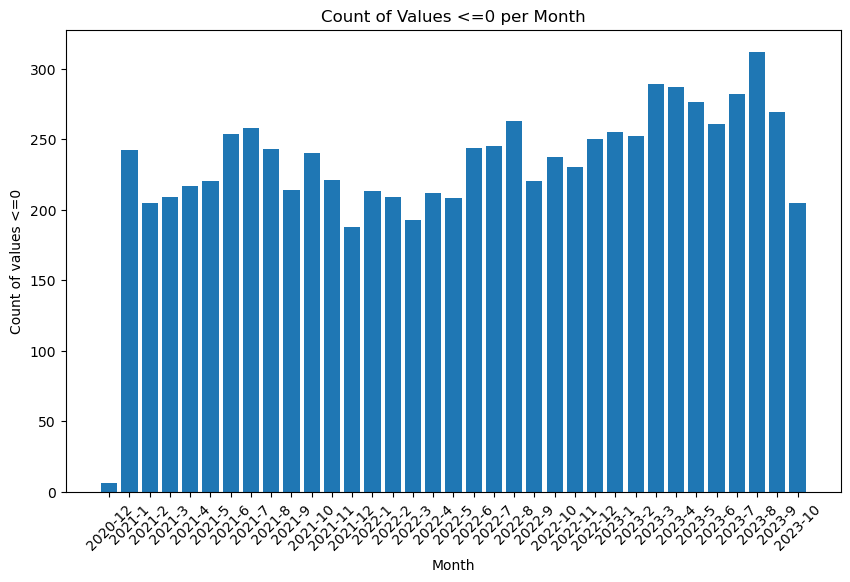

In [16]:
# Obtener el mes y el año de cada fecha
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Filtrar los valores menores o iguales a cero
negative_values = df[df['amount'] <= 0]

# Contar los valores negativos por mes y año
negative_counts = negative_values.groupby(['year', 'month']).size().reset_index(name='count')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(negative_counts.index, negative_counts['count'])
plt.xlabel('Month')
plt.ylabel('Count of values <=0')
plt.title('Count of Values <=0 per Month')
plt.xticks(ticks=negative_counts.index, labels=negative_counts.apply(lambda x: f"{x['year']}-{x['month']}", axis=1), rotation=45)
plt.show()

In [17]:
df.date.min(), df.date.max() # Timeframe

(Timestamp('2020-12-31 00:00:00'), Timestamp('2023-10-21 00:00:00'))

In [18]:
df.info() # summary

<class 'pandas.core.frame.DataFrame'>
Index: 101698 entries, 0 to 103725
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   payer    101698 non-null  object        
 1   country  101698 non-null  object        
 2   date     101698 non-null  datetime64[ns]
 3   count    101698 non-null  int64         
 4   amount   101698 non-null  float64       
 5   month    101698 non-null  int32         
 6   year     101698 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 5.4+ MB


In [19]:
df.head()

,payer,country,date,count,amount,month,year
0,PROMERICA (GUA),GUATEMALA,2023-01-02,63,32765.79,1,2023
1,GLOBAL ENVIOS,ECUADOR,2022-01-28,64,34550.00,1,2022
2,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2022-11-08,53,25407.00,11,2022
3,ZEEPAY,GHANA,2022-08-17,39,12809.00,8,2022
4,BANCO DE GUAYAQUIL,ECUADOR,2022-08-19,133,33700.17,8,2022


In [20]:
df[df.date.isnull()]

,payer,country,date,count,amount,month,year


In [21]:
len(df)

101698

In [22]:
df.country.nunique()

78

In [23]:
df[df.country.isnull()]

,payer,country,date,count,amount,month,year


In [24]:
df.country.unique()

array(['GUATEMALA', 'ECUADOR', 'EL SALVADOR', 'GHANA', 'SIERRA LEONE',
       'NIGERIA', 'MALI', 'MEXICO', 'PERU', 'DOMINICAN REPUBLIC', 'SPAIN',
       'UNITED STATES (ATM & DEPOSITS)', 'HONDURAS', 'BOLIVIA',
       "COTE D'IVOIRE (IVORY COAST)", 'CHILE', 'GUINEA', 'UNITED STATES',
       'SENEGAL', 'TOGO', 'COLOMBIA', 'NICARAGUA', 'GAMBIA, THE',
       'BURKINA FASO', 'PHILIPPINES', 'BANGLADESH', 'PORTUGAL', 'INDIA',
       'INDONESIA', 'ARGENTINA', 'HAITI', 'KENYA', 'CAMEROON', 'FRANCE',
       'BENIN', 'LIBERIA', 'SWITZERLAND', 'ITALY', 'NEPAL', 'URUGUAY',
       'THAILAND', 'MALAYSIA', 'BELGIUM', 'BRAZIL', 'NETHERLANDS',
       'ZAMBIA', 'UNITED KINGDOM', 'ETHIOPIA', 'IRELAND', 'JAMAICA',
       'GERMANY', 'GABON', 'COSTA RICA', 'LITHUANIA', 'QATAR', 'UGANDA',
       'SRI LANKA', 'CHAD', 'PAKISTAN', 'GREECE', 'MAURITANIA', 'NORWAY',
       'TANZANIA', 'FIJI', 'RWANDA', 'AUSTRIA',
       'CONGO, (CONGO Â– BRAZZAVILLE)', 'SINGAPORE', 'CAMBODIA',
       'ROMANIA', 'VIETNAM', 'ZIMBABW

In [25]:
df[df.country == 'UNITED STATES (ATM & DEPOSITS)']

,payer,country,date,count,amount,month,year
14,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2021-10-02,1,360.00,10,2021
76,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2021-01-10,13,6109.00,1,2021
87,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2023-07-16,5,5740.01,7,2023
100,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2022-08-01,11,6840.61,8,2022
111,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2022-02-17,1,-200.00,2,2022
...,...,...,...,...,...,...,...
103638,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2022-03-19,3,800.00,3,2022
103665,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2022-01-23,3,2930.00,1,2022
103674,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2021-08-07,2,500.00,8,2021
103716,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2022-06-29,1,-220.00,6,2022


In [26]:
df['payer'].nunique()

143

In [27]:
df.payer.unique()

array(['PROMERICA (GUA)', 'GLOBAL ENVIOS',
       'BANCO DAVIVIENDA SALVADORENO (BTS)', 'ZEEPAY',
       'BANCO DE GUAYAQUIL', 'AFRO INTERNACIONAL', 'NAIRAGRAM',
       'TRANSFERTO - THUNES', 'NAFA', 'AIRPAK', 'EXPIRED ORDERS',
       'BANCO BHD LEON', 'MASTERCARD ATM NETWORK',
       'DAVIVIENDA - HONDURAS (BTS)', 'BAM - BANCO AGROMERCANTIL (UT)',
       'BANCO BISA', 'AFEX', 'TELECOMM TELEGRAFOS (BTS)', 'ARGENPER',
       'BANCO GANADERO (BOLIVIA)', 'BANPAIS (RED CHAPINA)',
       'CHEDRAUI (APPRIZA)', 'INTERBANK', 'BANHCAFE', 'ECUAGIROS',
       'COOPERATIVA CACIL (UT)', 'VIAMERICAS USA DEPOSITS',
       'BANCO DEL AUSTRO', 'WALDOS (APPRIZA)', 'TRANSPAY',
       'DEPOSITOS BANCARIOS GUATEMALA - ACH', 'CREDOMATIC (BTS)',
       'CIBAO EXPRESS', 'KORI', 'SPEED MONEY', 'MERCHANTRADE',
       'BANCO INDUSTRIAL GT ATM (RED CHAPINA)', 'VTN', 'METROBANK',
       'ENVICON (ANTERIORMENTE ENVIOS CONFIANZA)',
       'BANCO POPULAR HONDURAS (UT)', 'BANCOPPEL (BTS)', 'YES BANK',
       'TIGO MON

In [28]:
df[df['payer'] == 'VIAMERICAS DEMO PAYER']

,payer,country,date,count,amount,month,year
2487,VIAMERICAS DEMO PAYER,MEXICO,2023-04-22,1,650.0,4,2023
75291,VIAMERICAS DEMO PAYER,MEXICO,2022-10-07,1,1.0,10,2022
75391,VIAMERICAS DEMO PAYER,MEXICO,2023-04-23,1,-650.0,4,2023
94884,VIAMERICAS DEMO PAYER,MEXICO,2022-10-10,1,-1.0,10,2022


In [29]:
df[df['payer'] == 'DEPOSITO MAS RAPIDO (REQUIERE ID BENEF)']

,payer,country,date,count,amount,month,year
34427,DEPOSITO MAS RAPIDO (REQUIERE ID BENEF),DOMINICAN REPUBLIC,2023-08-11,5,125.0,8,2023
91100,DEPOSITO MAS RAPIDO (REQUIERE ID BENEF),DOMINICAN REPUBLIC,2023-10-05,5,-105.0,10,2023
102419,DEPOSITO MAS RAPIDO (REQUIERE ID BENEF),DOMINICAN REPUBLIC,2023-08-18,1,5.0,8,2023


In [30]:
df[df['payer'] == 'PAGOS INTERNACIONALES']

,payer,country,date,count,amount,month,year
45504,PAGOS INTERNACIONALES,COLOMBIA,2021-01-06,1,-75.00,1,2021
53986,PAGOS INTERNACIONALES,COLOMBIA,2021-01-20,1,145.63,1,2021
62247,PAGOS INTERNACIONALES,COLOMBIA,2021-01-21,1,-145.63,1,2021
101315,PAGOS INTERNACIONALES,COLOMBIA,2021-01-03,1,75.00,1,2021


In [31]:
df[df['payer'] == 'EXPIRED ORDERS']

,payer,country,date,count,amount,month,year
10,EXPIRED ORDERS,PERU,2021-08-13,2,-226.0,8,2021
30,EXPIRED ORDERS,MEXICO,2023-02-20,12,-5490.0,2,2023
50,EXPIRED ORDERS,MEXICO,2022-04-19,19,-10564.0,4,2022
51,EXPIRED ORDERS,GUATEMALA,2022-08-02,6,-1357.0,8,2022
83,EXPIRED ORDERS,COLOMBIA,2022-02-04,1,-2000.0,2,2022
...,...,...,...,...,...,...,...
103686,EXPIRED ORDERS,GUATEMALA,2021-12-24,2,-92.0,12,2021
103706,EXPIRED ORDERS,ARGENTINA,2022-09-26,1,-30.0,9,2022
103707,EXPIRED ORDERS,UNITED STATES,2021-01-16,1,-3000.0,1,2021
103712,EXPIRED ORDERS,HONDURAS,2021-04-30,1,-3400.0,4,2021


In [32]:
df[df.payer.isnull()] # No null rows

,payer,country,date,count,amount,month,year


In [33]:
df[df['count'].isnull()]

,payer,country,date,count,amount,month,year


TOP COUNTRIES BY # TX

In [35]:
# Top50 dates based on 'count'
top_50_dates = df['date'].value_counts().head(50).index

# Marcar si la fecha está entre las top 50
df['top50dates'] = df['date'].isin(top_50_dates)

In [36]:
df[df['top50dates'] == True].sort_values('count', ascending=False).head(30)

,payer,country,date,count,amount,month,year,top50dates
42062,ELEKTRA (MEXICO),MEXICO,2023-10-21,28167,1.305305e+07,10,2023,True
86400,ELEKTRA (MEXICO),MEXICO,2023-05-09,25163,9.383064e+06,5,2023,True
94571,ELEKTRA (MEXICO),MEXICO,2023-05-08,24713,1.061218e+07,5,2023,True
67471,ELEKTRA (MEXICO),MEXICO,2023-10-20,23803,1.167145e+07,10,2023,True
88312,ELEKTRA (MEXICO),MEXICO,2023-07-29,23231,1.060913e+07,7,2023,True
84027,ELEKTRA (MEXICO),MEXICO,2023-09-22,23052,1.121878e+07,9,2023,True
41416,ELEKTRA (MEXICO),MEXICO,2023-06-16,22942,1.080915e+07,6,2023,True
54799,ELEKTRA (MEXICO),MEXICO,2023-10-06,22154,1.106107e+07,10,2023,True
15315,ELEKTRA (MEXICO),MEXICO,2023-08-18,21109,1.000801e+07,8,2023,True
48227,ELEKTRA (MEXICO),MEXICO,2023-09-29,20752,9.736629e+06,9,2023,True


In [37]:
df[df['top50dates'] == True].sort_values('count', ascending=False).tail(30)

,payer,country,date,count,amount,month,year,top50dates
90362,TRANSFERTO - THUNES,FRANCE,2023-10-04,1,120.00,10,2023,True
90365,TRANSPAY,INDONESIA,2023-07-29,1,500.00,7,2023,True
90371,TRANSPAY,INDONESIA,2023-05-08,1,2016.92,5,2023,True
34426,MFS AFRICA,TOGO,2023-09-18,1,25.00,9,2023,True
34444,TRANSFERTO - THUNES,GERMANY,2023-09-18,1,222.51,9,2023,True
90773,ENVICON (ANTERIORMENTE ENVIOS CONFIANZA),MEXICO,2023-03-28,1,1000.00,3,2023,True
38988,TRANSFERTO - THUNES,AUSTRIA,2023-06-22,1,166.66,6,2023,True
38661,MERCHANTRADE,THAILAND,2023-06-07,1,800.00,6,2023,True
38675,KORI,COTE D'IVOIRE (IVORY COAST),2023-06-19,1,10.00,6,2023,True
38706,TRANSFERTO - THUNES,ITALY,2023-04-12,1,192.00,4,2023,True


TRANSACTIONS PER MONTH

In [38]:
# Top10 countries / month and % they represent compared to the total transactions for each month 

# Grouping countries
grouped_by_country_month = df.groupby(['country', df['date'].dt.to_period('M')])['amount'].sum().reset_index()

# Sorting countries by total transaction amounts in each month
top_10_countries = grouped_by_country_month.groupby('date').apply(lambda x: x.nlargest(10, 'amount')).reset_index(drop=True)

# Total transactions per month
total_transactions_per_month = grouped_by_country_month.groupby('date')['amount'].sum().reset_index()

# Top 10 countries with total transactions per month
result = pd.merge(top_10_countries, total_transactions_per_month, on='date', suffixes=('_top_10', '_total'))

# Percentage of the top 10 countries compared to total transactions per month
result['percentage_of_total'] = (result['amount_top_10'] / result['amount_total']) * 100

In [39]:
result.head(30) # The first 4 are always the same, and they accumulate around 85% of the total for each month

,country,date,amount_top_10,amount_total,percentage_of_total
0,MEXICO,2020-12,5.301353e+06,8.460565e+06,62.659564
1,GUATEMALA,2020-12,1.485561e+06,8.460565e+06,17.558653
2,HONDURAS,2020-12,4.395329e+05,8.460565e+06,5.195078
3,EL SALVADOR,2020-12,4.131780e+05,8.460565e+06,4.883575
4,BRAZIL,2020-12,2.602153e+05,8.460565e+06,3.075626
5,DOMINICAN REPUBLIC,2020-12,1.620815e+05,8.460565e+06,1.915730
6,COLOMBIA,2020-12,1.173743e+05,8.460565e+06,1.387311
7,ECUADOR,2020-12,1.108980e+05,8.460565e+06,1.310764
8,PHILIPPINES,2020-12,5.053217e+04,8.460565e+06,0.597267
9,COSTA RICA,2020-12,3.118900e+04,8.460565e+06,0.368640


In [40]:
# Top5 and % transactions over total, by month
results_sorted = result.sort_values(['date', 'amount_top_10'], ascending=[True, False])

top_5_countries_per_month = results_sorted.groupby('date').head(5)

In [41]:
top_5_countries_per_month.head(30)

,country,date,amount_top_10,amount_total,percentage_of_total
0,MEXICO,2020-12,5.301353e+06,8.460565e+06,62.659564
1,GUATEMALA,2020-12,1.485561e+06,8.460565e+06,17.558653
2,HONDURAS,2020-12,4.395329e+05,8.460565e+06,5.195078
3,EL SALVADOR,2020-12,4.131780e+05,8.460565e+06,4.883575
4,BRAZIL,2020-12,2.602153e+05,8.460565e+06,3.075626
10,MEXICO,2021-01,2.202079e+08,4.053935e+08,54.319547
11,GUATEMALA,2021-01,8.994255e+07,4.053935e+08,22.186477
12,EL SALVADOR,2021-01,2.244730e+07,4.053935e+08,5.537162
13,HONDURAS,2021-01,2.053844e+07,4.053935e+08,5.066296
14,BRAZIL,2021-01,1.626068e+07,4.053935e+08,4.011085


In [42]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'MEXICO'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,3.901068e+08,7.173885e+08,54.725419
std,1.219201e+08,2.294079e+08,1.806990
min,5.301353e+06,8.460565e+06,52.285155
25%,3.114947e+08,5.645125e+08,53.356940
50%,4.040725e+08,7.442559e+08,54.828385
75%,4.758407e+08,8.617354e+08,55.532107
max,6.037689e+08,1.103410e+09,62.659564


In [43]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'EL SALVADOR'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,3.258615e+07,7.173885e+08,4.653857
std,8.544812e+06,2.294079e+08,0.496069
min,4.131780e+05,8.460565e+06,3.897811
25%,2.793337e+07,5.645125e+08,4.215120
50%,3.309885e+07,7.442559e+08,4.602943
75%,3.646198e+07,8.617354e+08,4.952326
max,4.621503e+07,1.103410e+09,5.803893


In [44]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'HONDURAS'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,4.006072e+07,7.173885e+08,5.514199
std,1.422577e+07,2.294079e+08,0.302663
min,4.395329e+05,8.460565e+06,4.960564
25%,3.043075e+07,5.645125e+08,5.311822
50%,4.253363e+07,7.442559e+08,5.566466
75%,4.737692e+07,8.617354e+08,5.755240
max,6.403766e+07,1.103410e+09,6.168009


In [45]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'BRAZIL'].describe()

,amount_top_10,amount_total,percentage_of_total
count,2.300000e+01,2.300000e+01,23.000000
mean,2.022068e+07,6.149371e+08,3.385870
std,5.164611e+06,2.075248e+08,0.543142
min,2.602153e+05,8.460565e+06,2.474876
25%,1.947929e+07,5.502732e+08,2.997524
50%,2.111557e+07,5.931224e+08,3.474379
75%,2.202128e+07,7.220093e+08,3.677008
max,2.730804e+07,1.103410e+09,4.671497


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


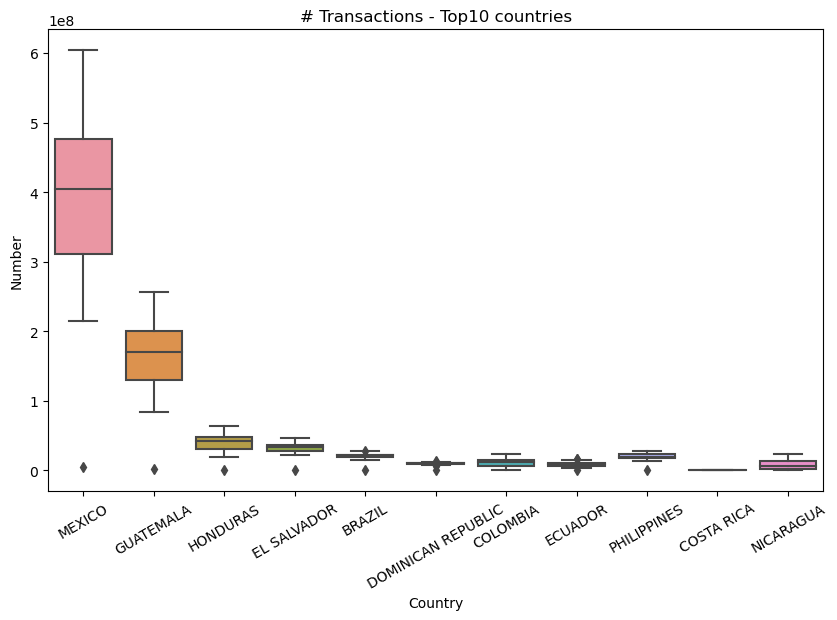

In [46]:
# Top10 Countries by # Transactions - Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='country', y='amount', data=top_10_countries)
plt.xlabel('Country')
plt.ylabel('Number')
plt.title('# Transactions - Top10 countries')
plt.xticks(rotation=30)
plt.show()

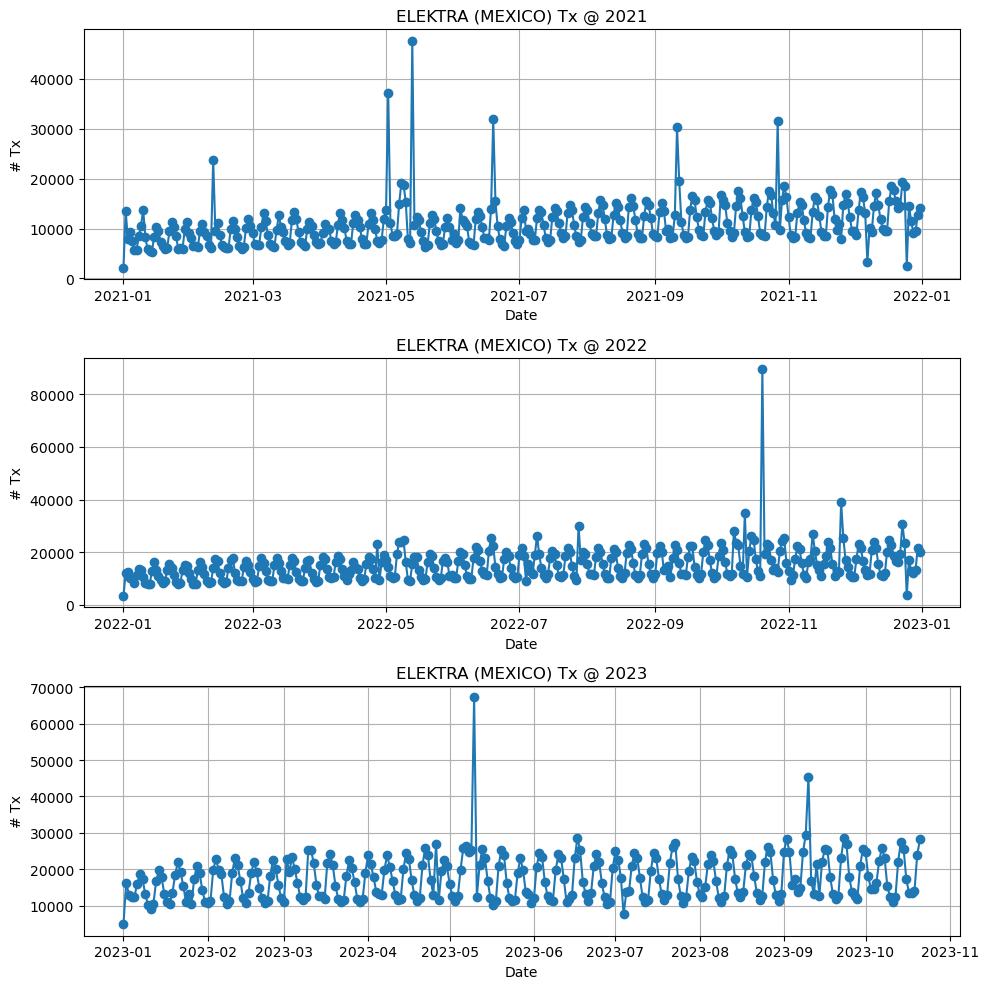

In [65]:
# 'ELEKTRA (MEXICO)' transactions (Tx)
elektra_transactions = df[df['payer'] == 'ELEKTRA (MEXICO)']

# Organizing data by year to check if we can find more relevant information related to peak dates
elektra_transactions_2021 = elektra_transactions[elektra_transactions['date'].dt.year == 2021]
elektra_transactions_2022 = elektra_transactions[elektra_transactions['date'].dt.year == 2022]
elektra_transactions_2023 = elektra_transactions[elektra_transactions['date'].dt.year == 2023]

# Grouping by date, count and year
elektra_transactions_by_date_2021 = elektra_transactions_2021.groupby('date')['count'].sum()
elektra_transactions_by_date_2022 = elektra_transactions_2022.groupby('date')['count'].sum()
elektra_transactions_by_date_2023 = elektra_transactions_2023.groupby('date')['count'].sum()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# 2021
axs[0].plot(elektra_transactions_by_date_2021, marker='o', linestyle='-')
axs[0].set_title('ELEKTRA (MEXICO) Tx @ 2021')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('# Tx')
axs[0].grid(True)

# 2022
axs[1].plot(elektra_transactions_by_date_2022, marker='o', linestyle='-')
axs[1].set_title('ELEKTRA (MEXICO) Tx @ 2022')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('# Tx')
axs[1].grid(True)

# 2023
axs[2].plot(elektra_transactions_by_date_2023, marker='o', linestyle='-')
axs[2].set_title('ELEKTRA (MEXICO) Tx @ 2023')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('# Tx')
axs[2].grid(True)

plt.tight_layout()
plt.show()


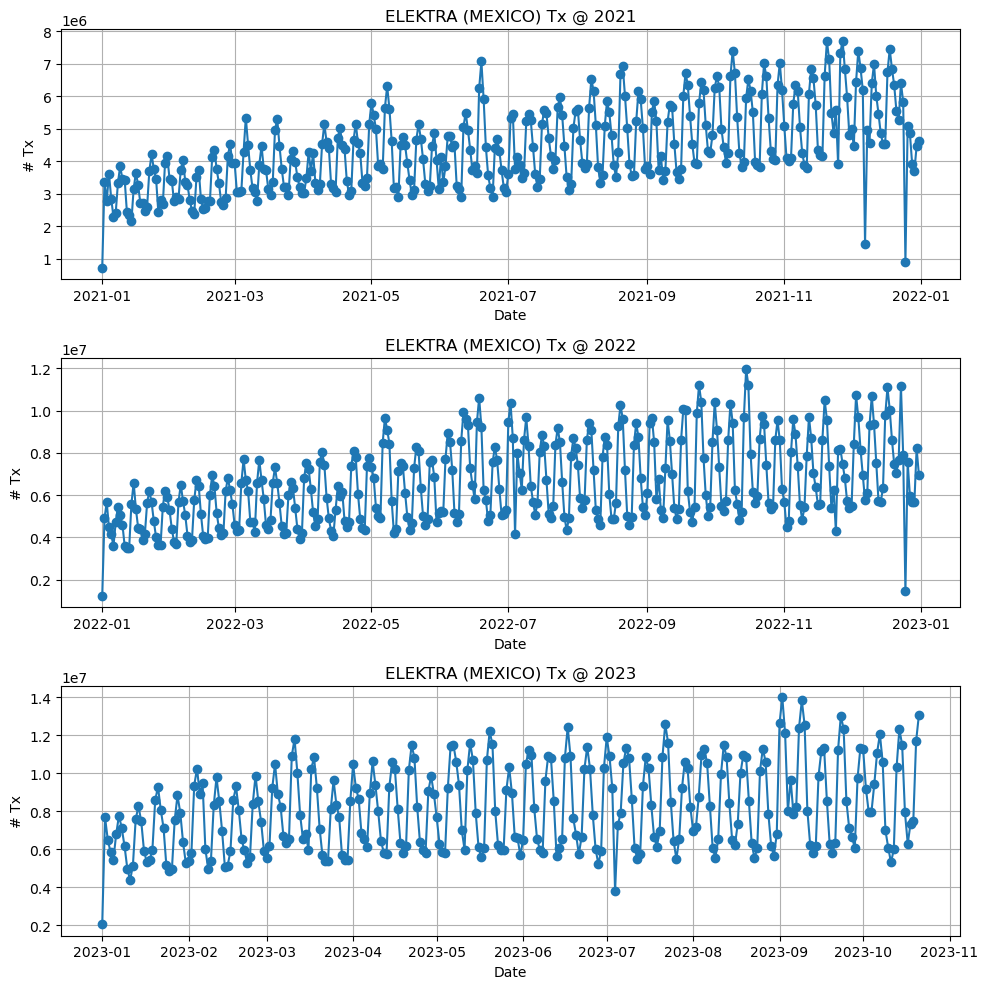

In [63]:
# Grouping by date, count and year
elektra_transactions_by_date_2021 = elektra_transactions_2021.groupby('date')['amount'].sum()
elektra_transactions_by_date_2022 = elektra_transactions_2022.groupby('date')['amount'].sum()
elektra_transactions_by_date_2023 = elektra_transactions_2023.groupby('date')['amount'].sum()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# 2021
axs[0].plot(elektra_transactions_by_date_2021, marker='o', linestyle='-')
axs[0].set_title('ELEKTRA (MEXICO) Tx @ 2021')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('# Tx')
axs[0].grid(True)

# 2022
axs[1].plot(elektra_transactions_by_date_2022, marker='o', linestyle='-')
axs[1].set_title('ELEKTRA (MEXICO) Tx @ 2022')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('# Tx')
axs[1].grid(True)

# 2023
axs[2].plot(elektra_transactions_by_date_2023, marker='o', linestyle='-')
axs[2].set_title('ELEKTRA (MEXICO) Tx @ 2023')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('# Tx')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [52]:
(elektra_transactions_2022['date'] > '2022-05-01')

1380      False
8803       True
9254       True
9322       True
9486       True
          ...  
101758    False
101854    False
101945     True
102022     True
103184     True
Name: date, Length: 365, dtype: bool

PAYER_COUNTRY

In [53]:
# Combining Payer + Country to be able to easily operate with them. Each combination is unique
df['payer_country'] = df['payer'] + '_' + df['country']

In [54]:
df.payer_country.nunique()

298

In [55]:
# Grouping by 'payer_country' and calculating the mean 'amount'
summary_table = df.groupby('payer_country')['amount'].mean().reset_index()

# Sorting the table by 'amount' in descending order
summary_table = summary_table.sort_values(by='amount', ascending=False)

In [56]:
summary_table.head(30)

,payer_country,amount
81,ELEKTRA (MEXICO)_MEXICO,6.243777e+06
36,BANCOPPEL (APPRIZA)_MEXICO,3.855704e+06
44,BANRURAL (RYT)_GUATEMALA,2.857622e+06
30,BANCO INDUSTRIAL_GUATEMALA,2.231564e+06
37,BANCOPPEL (BTS)_MEXICO,1.651232e+06
47,BBVA - BANCOMER (BTS)_MEXICO,6.472490e+05
85,ENVIOS CON CLABE (APPRIZA)_MEXICO,5.965213e+05
40,BANORTE (UT)_MEXICO,4.672486e+05
213,TELECOMM TELEGRAFOS (APPRIZA)_MEXICO,4.515509e+05
24,BANCO DE OCCIDENTE_HONDURAS,4.279335e+05


In [57]:
summary_table = summary_table.head(50) #Filtering top50 

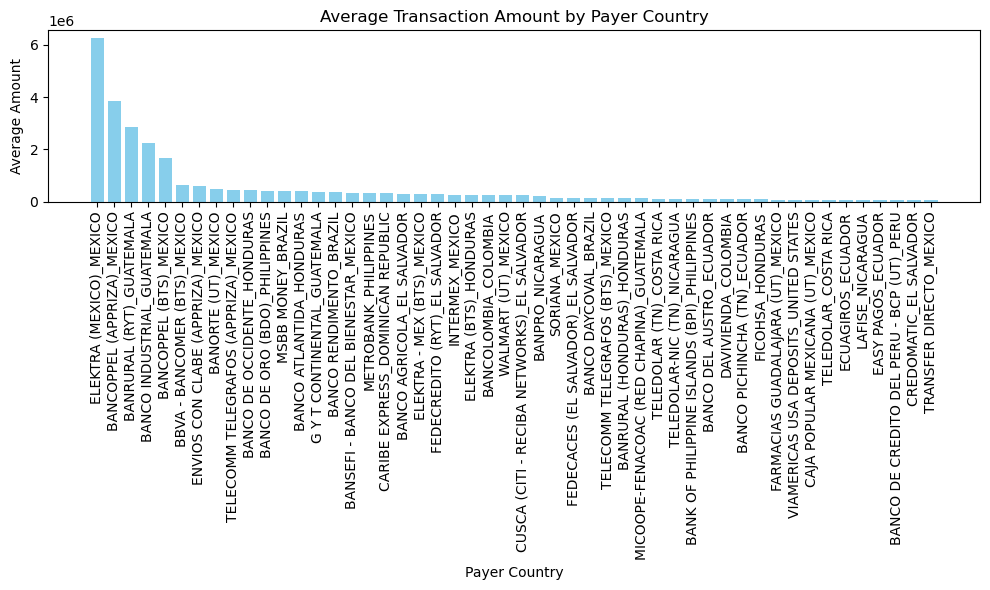

In [58]:
# Bars plot
plt.figure(figsize=(10, 6))
plt.bar(summary_table['payer_country'], summary_table['amount'], color='skyblue')

# Setting
plt.xticks(rotation=90)

# Labels
plt.xlabel('Payer Country')
plt.ylabel('Average Amount')
plt.title('Average Transaction Amount by Payer Country')

plt.tight_layout()
plt.show()

TIME SERIES ANALYSIS

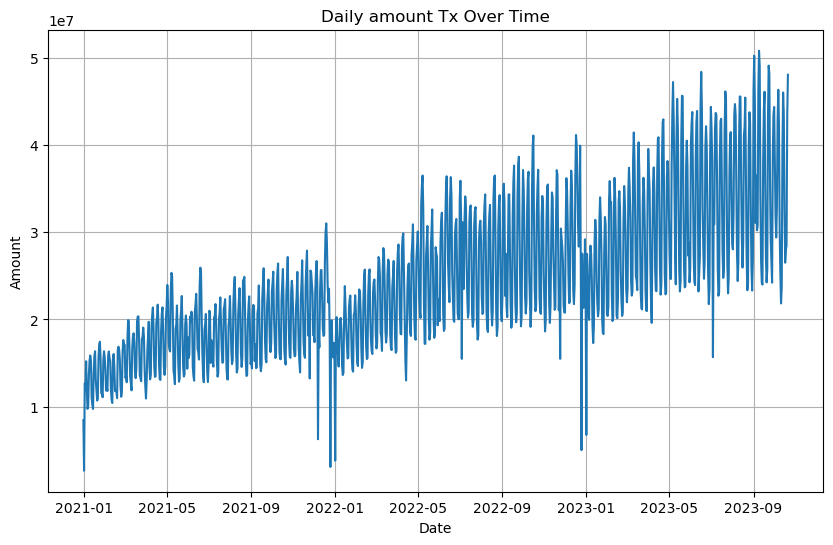

In [59]:
# Grouping by date
daily_amount = df.groupby('date')['amount'].sum()

plt.figure(figsize=(10, 6))
plt.plot(daily_amount)
plt.title('Daily amount Tx Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

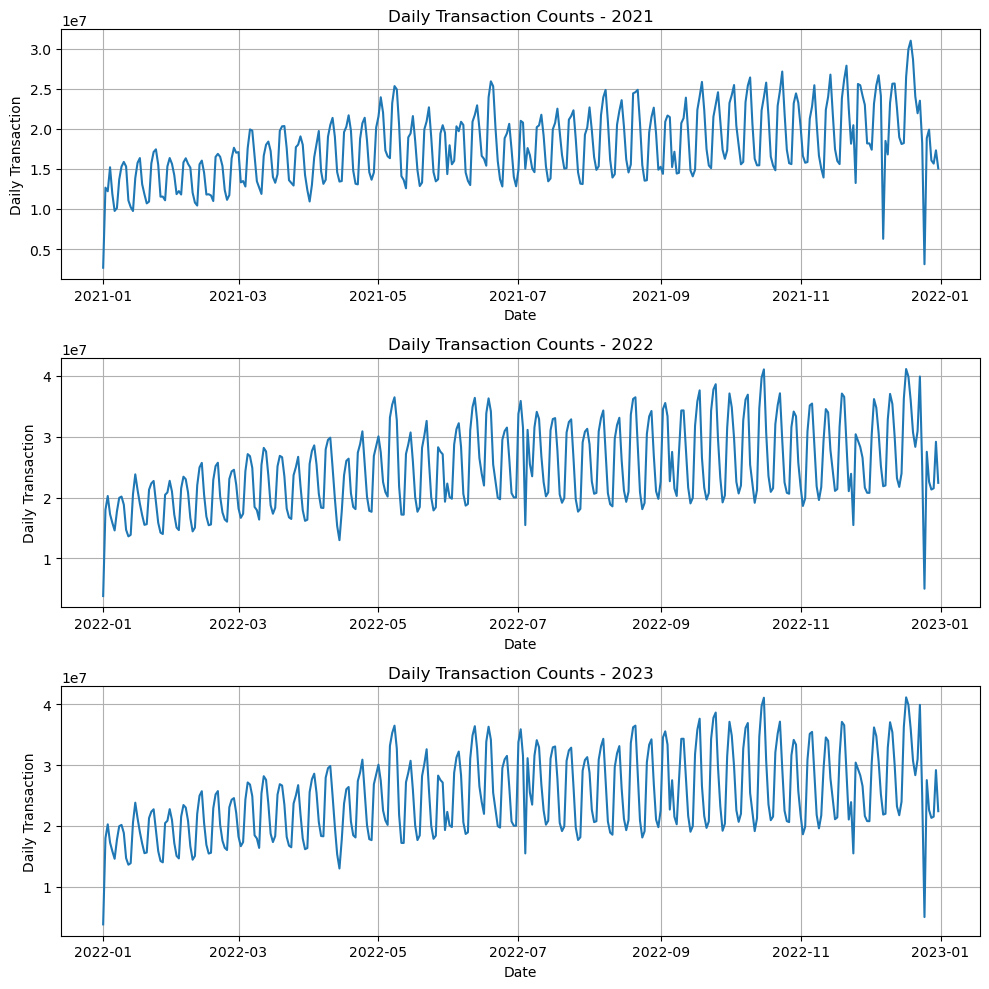

In [61]:
# Splitting by year
daily_amount_2021 = daily_amount['2021']
daily_amount_2022 = daily_amount['2022']
daily_amount_2023 = daily_amount['2023']

# Subplotting by year
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# 2021
axs[0].plot(daily_amount_2021)
axs[0].set_title('Daily Transaction Counts - 2021')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Daily Transaction')
axs[0].grid(True)

# 2022
axs[1].plot(daily_amount_2022)
axs[1].set_title('Daily Transaction Counts - 2022')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Daily Transaction')
axs[1].grid(True)

# 2023
axs[2].plot(daily_amount_2022)
axs[2].set_title('Daily Transaction Counts - 2023')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Daily Transaction')
axs[2].grid(True)

# Settings
plt.tight_layout()
plt.show()


In [62]:
daily_amount_df = daily_amount.reset_index()

In [63]:
# Top days by 'amount'
daily_amount_df.sort_values('amount', ascending=False).head(30)

,date,amount
982,2023-09-09,5.078457e+07
975,2023-09-02,5.021364e+07
996,2023-09-23,4.907446e+07
983,2023-09-10,4.899572e+07
898,2023-06-17,4.835938e+07
997,2023-09-24,4.817330e+07
1024,2023-10-21,4.803398e+07
857,2023-05-07,4.720037e+07
1010,2023-10-07,4.630589e+07
974,2023-09-01,4.626688e+07


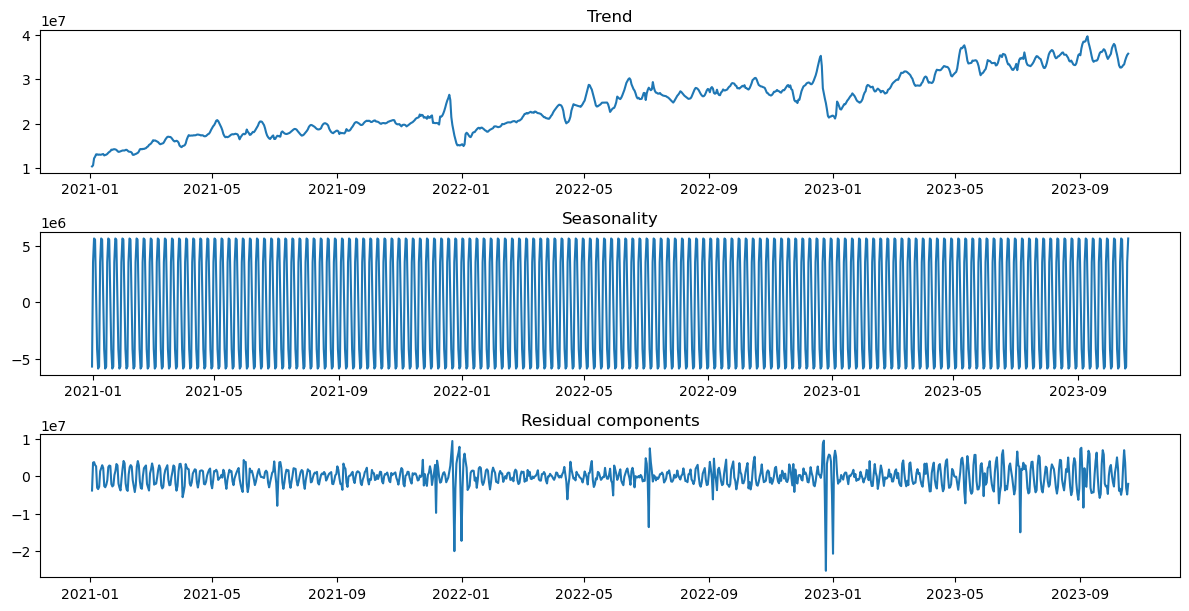

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal
decomposition = seasonal_decompose(daily_amount, model='additive')

# Gráficos para cada componente (tendencia, estacionalidad y residuo)
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residual components')

plt.tight_layout()
plt.show()

In [65]:
# Extract the trend, seasonality, and residual components

# Convert the decomposed components into DataFrames
trend_df = pd.DataFrame({'Trend': decomposition.trend})
seasonal_df = pd.DataFrame({'Seasonal': decomposition.seasonal})
residual_df = pd.DataFrame({'Residual': decomposition.resid})

In [66]:
decomposition_df = pd.concat([trend_df, seasonal_df, residual_df], axis=1)

In [67]:
decomposition_df.head(20)

,Trend,Seasonal,Residual
date,,,
2020-12-31,NaN,-5.690258e+06,NaN
2021-01-01,NaN,3.570099e+06,NaN
2021-01-02,NaN,5.669779e+06,NaN
2021-01-03,1.040457e+07,5.566711e+06,-3.764757e+06
2021-01-04,1.064033e+07,9.014429e+05,3.665732e+06
2021-01-05,1.221385e+07,-4.147512e+06,3.811477e+06
2021-01-06,1.258969e+07,-5.870262e+06,3.032459e+06
2021-01-07,1.311351e+07,-5.690258e+06,2.687607e+06
2021-01-08,1.312766e+07,3.570099e+06,-3.016405e+06


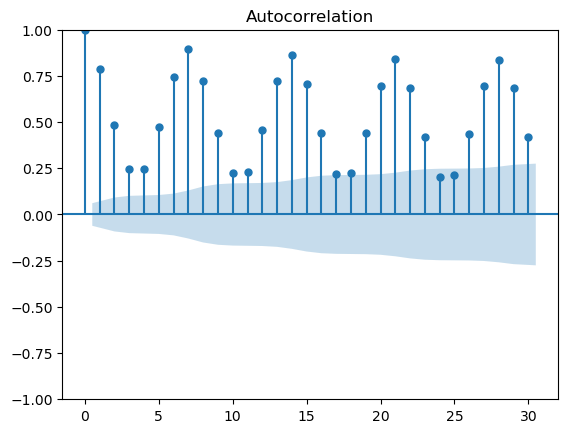

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


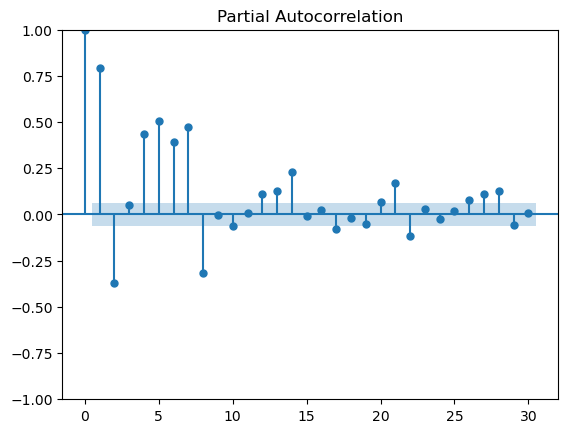

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelación
plot_acf(daily_amount, lags=30)
plt.title('Autocorrelation')
plt.show()

# Autocorrelación parcial
plot_pacf(daily_amount, lags=30)
plt.title('Partial Autocorrelation')
plt.show()

In [69]:
from statsmodels.tsa.stattools import acf, pacf

# ACF & PACF
lags = 30
acf_vals = acf(daily_amount, nlags=lags)
pacf_vals = pacf(daily_amount, nlags=lags)

# Crear un DataFrame con los resultados
results = pd.DataFrame({'ACF': acf_vals, 'PACF': pacf_vals})
results.index.name = 'Lag'

results

,ACF,PACF
Lag,,
0,1.000000,1.000000
1,0.789508,0.790279
2,0.484078,-0.371591
3,0.247282,0.049228
4,0.246233,0.436895
5,0.473316,0.506305
6,0.744706,0.390500
7,0.897692,0.475062
8,0.722567,-0.316857


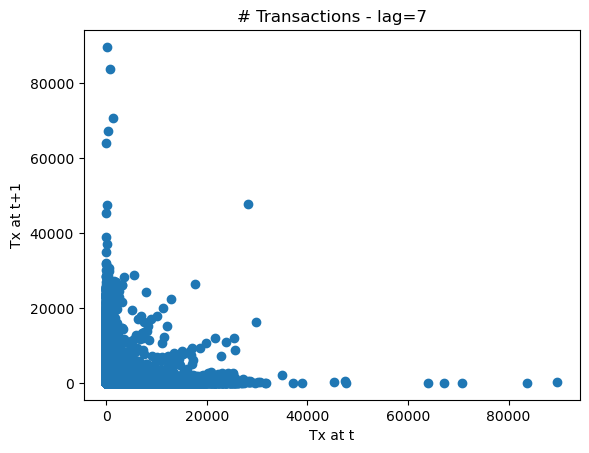

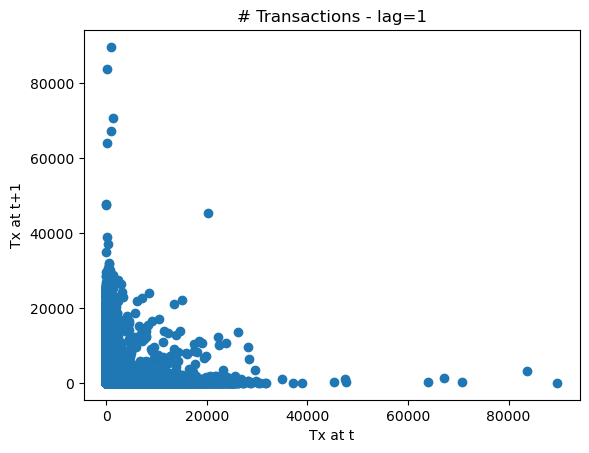

In [70]:
# Lag Plotting - To detect patterns or not in time series, by plotting obs against their lagged values

pd.plotting.lag_plot(df['count'], lag=7)
plt.title('# Transactions - lag=7')
plt.xlabel('Tx at t')
plt.ylabel('Tx at t+1')
plt.show()


pd.plotting.lag_plot(df['count'], lag=1)
plt.title('# Transactions - lag=1')
plt.xlabel('Tx at t')
plt.ylabel('Tx at t+1')
plt.show()


In [71]:
df.head()

,payer,country,date,count,amount,month,year,top50dates,payer_country
35805,ENVIOS CON CLABE (APPRIZA),MEXICO,2020-12-31,441,147611.120,12,2020,False,ENVIOS CON CLABE (APPRIZA)_MEXICO
84927,BANCO DEL AUSTRO,ECUADOR,2020-12-31,144,38783.000,12,2020,False,BANCO DEL AUSTRO_ECUADOR
53313,COOPERATIVA CACIL (UT),HONDURAS,2020-12-31,3,1200.000,12,2020,False,COOPERATIVA CACIL (UT)_HONDURAS
85964,BANPRO,NICARAGUA,2020-12-31,136,28510.645,12,2020,False,BANPRO_NICARAGUA
94674,TRANSFERTO - THUNES,SENEGAL,2020-12-31,2,467.000,12,2020,False,TRANSFERTO - THUNES_SENEGAL


<AxesSubplot:title={'center':'Average Transactions by Weekday'}, xlabel='Weekday', ylabel='Average Transactions'>

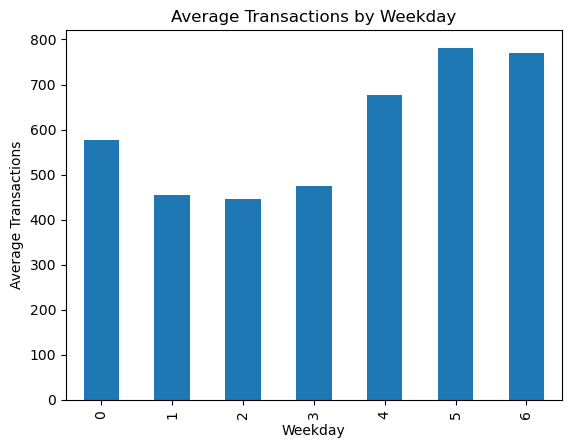

In [72]:
# Extract weekday from date column (assuming 'date' is your date column)
df['weekday'] = df['date'].dt.weekday

# Group by weekday and calculate average transactions
weekday_transactions_tx = df.groupby('weekday')['count'].mean()

# Plotting
weekday_transactions_tx.plot(kind='bar', xlabel='Weekday', ylabel='Average Transactions', title='Average Transactions by Weekday')

In [73]:
df

,payer,country,date,count,amount,month,year,top50dates,payer_country,weekday
35805,ENVIOS CON CLABE (APPRIZA),MEXICO,2020-12-31,441,147611.120,12,2020,False,ENVIOS CON CLABE (APPRIZA)_MEXICO,3
84927,BANCO DEL AUSTRO,ECUADOR,2020-12-31,144,38783.000,12,2020,False,BANCO DEL AUSTRO_ECUADOR,3
53313,COOPERATIVA CACIL (UT),HONDURAS,2020-12-31,3,1200.000,12,2020,False,COOPERATIVA CACIL (UT)_HONDURAS,3
85964,BANPRO,NICARAGUA,2020-12-31,136,28510.645,12,2020,False,BANPRO_NICARAGUA,3
94674,TRANSFERTO - THUNES,SENEGAL,2020-12-31,2,467.000,12,2020,False,TRANSFERTO - THUNES_SENEGAL,3
...,...,...,...,...,...,...,...,...,...,...
73712,EXPIRED ORDERS,ECUADOR,2023-10-21,1,-150.000,10,2023,True,EXPIRED ORDERS_ECUADOR,5
74688,TRANSPAY,SENEGAL,2023-10-21,2,2074.000,10,2023,True,TRANSPAY_SENEGAL,5
74720,TRANSFERTO - THUNES,PORTUGAL,2023-10-21,1,600.000,10,2023,True,TRANSFERTO - THUNES_PORTUGAL,5
72647,EXPIRED ORDERS,HONDURAS,2023-10-21,2,-275.000,10,2023,True,EXPIRED ORDERS_HONDURAS,5


<AxesSubplot:title={'center':'Acumulated Amount by Weekday'}, xlabel='Weekday', ylabel='Amount operated by day'>

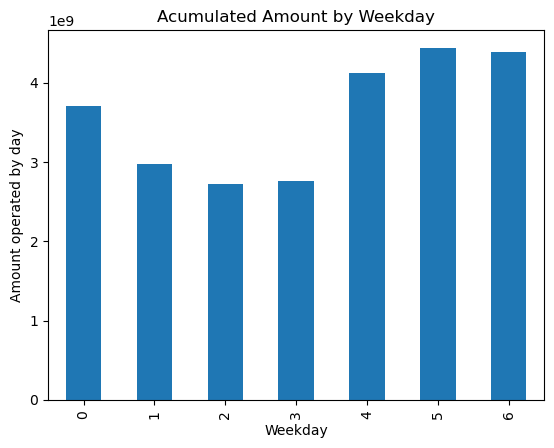

In [74]:
# Group by weekday and calculate average transactions
weekday_transactions_amout = df.groupby('weekday')['amount'].sum()

# Plotting
weekday_transactions_amout.plot(kind='bar', xlabel='Weekday', ylabel='Amount operated by day', title='Acumulated Amount by Weekday')

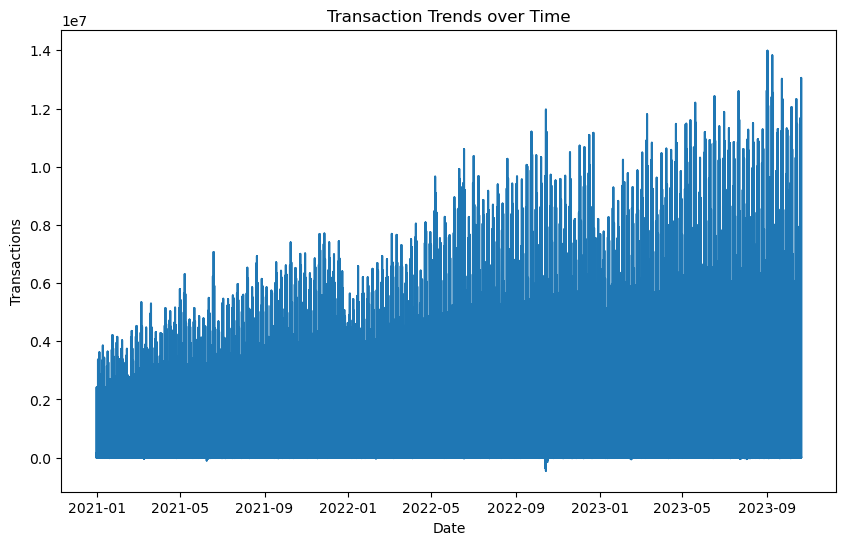

In [75]:
# Transaction Trends over Time
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['amount'])
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Transaction Trends over Time')
plt.show()

In [76]:
#df.reset_index(inplace=True)

In [67]:
df.head()

,payer,country,date,count,amount,month,year,top50dates,payer_country
0,PROMERICA (GUA),GUATEMALA,2023-01-02,63,32765.79,1,2023,False,PROMERICA (GUA)_GUATEMALA
1,GLOBAL ENVIOS,ECUADOR,2022-01-28,64,34550.00,1,2022,False,GLOBAL ENVIOS_ECUADOR
2,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2022-11-08,53,25407.00,11,2022,False,BANCO DAVIVIENDA SALVADORENO (BTS)_EL SALVADOR
3,ZEEPAY,GHANA,2022-08-17,39,12809.00,8,2022,False,ZEEPAY_GHANA
4,BANCO DE GUAYAQUIL,ECUADOR,2022-08-19,133,33700.17,8,2022,False,BANCO DE GUAYAQUIL_ECUADOR
